## **Table 1. Necessary dependencies to run the codes**

In [ ]:
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime, time
from datetime import datetime, date
import math
from datetime import datetime, date
from math import log, sqrt, pi, exp, erf
from scipy.stats import norm
!pip install arch
from arch import arch_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from datetime import date
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta, FR
from matplotlib.ticker import PercentFormatter
!pip install pandas_market_calendars
from enum import Enum
import pandas_market_calendars as mcal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

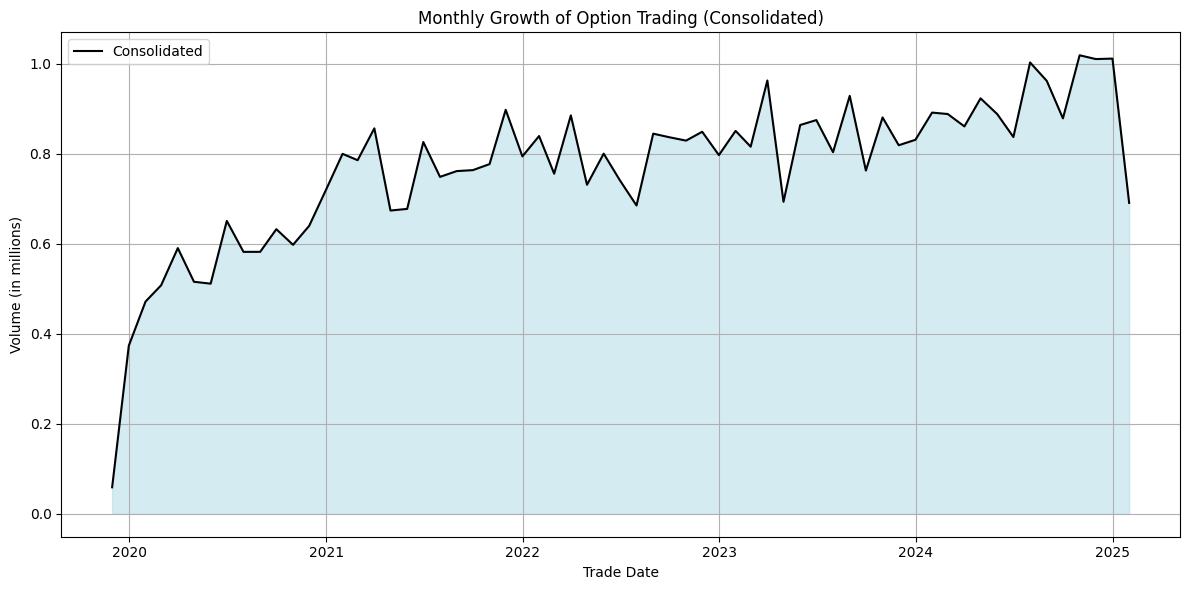

In [ ]:
df = pd.read_csv('/content/US_Equity_Options_Volume.csv')
df['Trade Date'] = pd.to_datetime(df['Trade Date'], format='%Y%m%d')
df.set_index('Trade Date', inplace=True)

df['Consolidated'] = df['Consolidated'].replace(',', '', regex=True).astype(float)
df['Consolidated_Millions'] = df['Consolidated'] / 1_000_000
monthly_df = df['Consolidated_Millions'].resample('ME').sum()

plt.figure(figsize = (12, 6))
plt.plot(monthly_df.index, monthly_df.values, color = 'k', label = 'Consolidated')
plt.fill_between(monthly_df.index, 0, monthly_df.values, color = 'lightblue', alpha=0.5)
plt.title('Monthly Growth of Option Trading (Consolidated)')
plt.xlabel('Trade Date')
plt.ylabel('Volume (in millions)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## **Table 2. List of available options**

In [ ]:
ticker = "AMZN"
option = yf.Ticker(ticker)
option.options

('2025-01-17',
 '2025-01-24',
 '2025-01-31',
 '2025-02-07',
 '2025-02-14',
 '2025-02-21',
 '2025-02-28',
 '2025-03-21',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17')

## **Table 3. Intermediate Value Calculations (d1 and d2) and Theoretical Option Price Calculations (BS_CALL and BS_PUT)**

In [ ]:
def standard_normal_cdf(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def d1(S0, K, T, r, sigma):
    numerator = log(S0/K) + (r + pow(sigma, 2)/2) * T
    denominator = sigma * sqrt(T)
    return numerator / denominator

def d2(S0, K, T, r, sigma):
    return d1(S0, K, T, r, sigma) - sigma * sqrt(T)

def BS_CALL(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * N(d1) - K * np.exp(-r*T) * N(d2)

def BS_PUT(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * N(-d2) - S0 * N(-d1)

In [ ]:
date = '2025-04-17'

def get_options_data(ticker_symbol, date):
    ticker = yf.Ticker(ticker_symbol)
    options_data = ticker.option_chain(date)
    return options_data.calls, options_data.puts

calls, puts = get_options_data(ticker, date)
calls = pd.DataFrame(calls)
print(calls.head())

        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  AMZN250417C00085000 2025-01-02 17:39:55+00:00    85.0     135.75  133.65   
1  AMZN250417C00090000 2024-12-27 17:13:22+00:00    90.0     133.25  128.70   
2  AMZN250417C00095000 2025-01-06 16:27:43+00:00    95.0     134.66  123.75   
3  AMZN250417C00100000 2025-01-14 18:25:12+00:00   100.0     119.73  117.95   
4  AMZN250417C00105000 2025-01-02 14:52:47+00:00   105.0     119.55  113.90   

      ask    change  percentChange  volume  openInterest  impliedVolatility  \
0  134.15  0.000000       0.000000       2            21           1.062749   
1  129.25  0.000000       0.000000       1             3           1.016362   
2  125.25  0.000000       0.000000       1             2           1.033208   
3  120.35  0.840004       0.706539       2            23           0.931641   
4  115.55  0.000000       0.000000       1            55           0.947754   

   inTheMoney contractSize currency  
0        Tru

## **Table 4. Option Pricing Parameters**

In [ ]:
def get_current_stock_price(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    return current_price

def get_13wk_treasury_rate():
    treasury_ticker = "^IRX"
    treasury_data = yf.download(treasury_ticker, period="1d")
    last_yield = treasury_data['Close'].iloc[-1]
    return last_yield

def get_date(date_str):
    date_object = datetime.strptime(date_str, '%Y-%m-%d')
    current_date = datetime.now()
    years_difference = (date_object - current_date).days / 365.25
    return years_difference

def calculate_volatility(ticker):
    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    data = yf.download(ticker, start=one_year_ago, end=today)
    data['Daily_Return'] = ((data['Close']/data['Close'].shift(1)) - 1) * 100
    data = data.dropna()
    daily_returns = data['Daily_Return']
    daily_volatility = data['Daily_Return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)

    return annualized_volatility

In [ ]:
S0 = get_current_stock_price(ticker)
T = get_date(date)
sigma = calculate_volatility(ticker)
r = get_13wk_treasury_rate().iloc[0]
r = r / 100
print()
print("Riskfree rate:", r)
print("Years difference:", T)
print("Current stock price:", S0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Riskfree rate: 0.04212999820709228
Years difference: 0.24914442162902123
Current stock price: 217.75999450683594


## **Table 5. Black-Scholes model valuation**

In [ ]:
calls.columns

Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency'],
      dtype='object')

In [ ]:
# 'lastTradeDate', 'lastPrice', 'volume', 'openInterest', 'contractSize', 'currency'

N = norm.cdf
DATA = calls[['contractSymbol', 'strike', 'bid', 'ask',
       'change', 'percentChange', 'impliedVolatility', 'inTheMoney']].copy()
DATA.loc[:, 'BS_Valuation'] = DATA.apply(lambda row: BS_CALL(S0, row['strike'], T, r, sigma), axis=1)
print(DATA.head())

        contractSymbol  strike     bid     ask    change  percentChange  \
0  AMZN250417C00085000    85.0  133.65  134.15  0.000000       0.000000   
1  AMZN250417C00090000    90.0  128.70  129.25  0.000000       0.000000   
2  AMZN250417C00095000    95.0  123.75  125.25  0.000000       0.000000   
3  AMZN250417C00100000   100.0  117.95  120.35  0.840004       0.706539   
4  AMZN250417C00105000   105.0  113.90  115.55  0.000000       0.000000   

   impliedVolatility  inTheMoney  BS_Valuation  
0           1.062749        True    217.759995  
1           1.016362        True    217.759995  
2           1.033208        True    217.759995  
3           0.931641        True    217.759995  
4           0.947754        True    217.759995  


## **Table 6. Greeks estimations**

In [ ]:
def delta_call(S0, K, T, r, sigma):
    return norm.cdf(d1(S0, K, T, r, sigma))

def gamma_call(S0, K, T, r, sigma):
    numerator = norm.pdf(d1(S0, K, T, r, sigma))
    denominator = S0 * sigma * sqrt(T)
    return numerator / denominator

def vega_call(S0, K, T, r, vol):
    return S0 * norm.pdf(d1(S0, K, T, r, sigma)) * sqrt(T)

def theta_call(S0, K, T, r, sigma):
    numerator = S0 * norm.pdf(d1(S0, K, T, r, sigma)) * sigma
    denominator = 2 * sqrt(T)
    theta_1 = -1 * (numerator / denominator)
    if isinstance(r, pd.Series):
        r = float(r.iloc[0])
    elif isinstance(T, pd.Series):
        T = float(T.iloc[0])
    theta_2 = -r * K * exp(-r * T) * norm.cdf(d2(S0, K, T, r, sigma))
    return theta_1 + theta_2

def rho_call(S0, K, T, r, sigma):
    if isinstance(r, pd.Series):
        r = float(r.iloc[0])
    elif isinstance(T, pd.Series):
        T = float(T.iloc[0])
    return K * T * exp(-r * T) * norm.cdf(d2(S0, K, T, r, sigma))

In [ ]:
gd = DATA.copy()
gd['delta'] = gd['strike'].apply(lambda K: delta_call(S0, K, T, r, sigma))
gd['gamma'] = gd['strike'].apply(lambda K: gamma_call(S0, K, T, r, sigma))
gd['vega'] = gd['strike'].apply(lambda K: vega_call(S0, K, T, r, sigma))
gd['theta'] = gd['strike'].apply(lambda K: theta_call(S0, K, T, r, sigma))
gd['rho'] = gd['strike'].apply(lambda K: rho_call(S0, K, T, r, sigma))
print(gd[['contractSymbol', 'BS_Valuation', 'delta',
          'gamma', 'vega', 'theta', 'rho']].tail())

         contractSymbol  BS_Valuation  delta         gamma          vega  \
48  AMZN250417C00325000    217.759995    1.0  3.715264e-15  1.230613e-09   
49  AMZN250417C00330000    217.759995    1.0  3.743618e-15  1.240005e-09   
50  AMZN250417C00335000    217.759995    1.0  3.771753e-15  1.249324e-09   
51  AMZN250417C00340000    217.759995    1.0  3.799673e-15  1.258572e-09   
52  AMZN250417C00345000    217.759995    1.0  3.827384e-15  1.267751e-09   

           theta           rho  
48 -6.925575e-08  8.576451e-11  
49 -6.978428e-08  8.640611e-11  
50 -7.030874e-08  8.704266e-11  
51 -7.082919e-08  8.767427e-11  
52 -7.134574e-08  8.830105e-11  


## **Table 7. Binomial stock price tree with 10 steps**

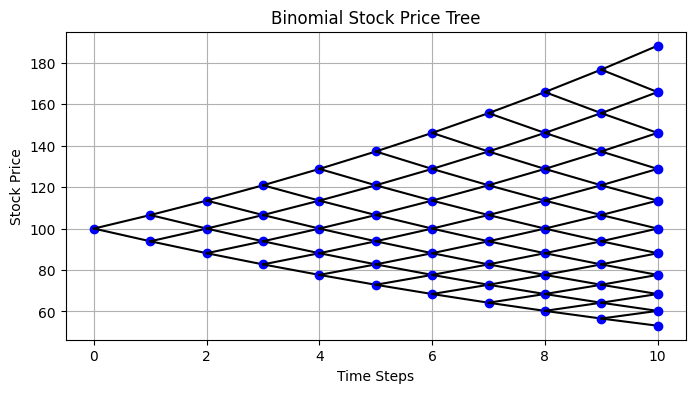

In [ ]:
def generate_stock_tree(S0, T, r, sigma, N = 10):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Initialize tree
    stock_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S0 * (u ** (i - j)) * (d ** j)
    return stock_tree

def plot_stock_tree(stock_tree):
    N = stock_tree.shape[1] - 1
    fig, ax = plt.subplots(figsize = (8, 4))

    for i in range(N + 1):
        for j in range(i + 1):
            x = i
            y = stock_tree[j, i]
            ax.plot(x, y, 'bo')

            if i < N:
                ax.plot([x, x + 1], [y, stock_tree[j, i + 1]], 'k-')
                ax.plot([x, x + 1], [y, stock_tree[j + 1, i + 1]], 'k-')

    ax.set_title("Binomial Stock Price Tree")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Stock Price")
    plt.grid(True)
    plt.show()

S0 = 100
T = 1.0
r = 0.05
sigma = 0.2
N = 10

stock_tree = generate_stock_tree(S0, T, r, sigma, N)
plot_stock_tree(stock_tree)

## **Table 8. Multi-step Binomial tree for American options**

In [ ]:
opt = option.option_chain('2025-04-17')

calls_strike_prices = opt.calls['strike']
puts_strike_prices = opt.puts['strike']

print("Calls Strike Prices:", calls_strike_prices)
print("Puts Strike Prices:", puts_strike_prices)

Calls Strike Prices: 0      85.0
1      90.0
2      95.0
3     100.0
4     105.0
5     110.0
6     115.0
7     120.0
8     125.0
9     130.0
10    135.0
11    140.0
12    145.0
13    150.0
14    155.0
15    160.0
16    165.0
17    170.0
18    175.0
19    180.0
20    185.0
21    190.0
22    195.0
23    200.0
24    205.0
25    210.0
26    215.0
27    220.0
28    225.0
29    230.0
30    235.0
31    240.0
32    245.0
33    250.0
34    255.0
35    260.0
36    265.0
37    270.0
38    275.0
39    280.0
40    285.0
41    290.0
42    295.0
43    300.0
44    305.0
45    310.0
46    315.0
47    320.0
48    325.0
49    330.0
50    335.0
51    340.0
52    345.0
Name: strike, dtype: float64
Puts Strike Prices: 0      85.0
1      90.0
2      95.0
3     100.0
4     105.0
5     110.0
6     115.0
7     120.0
8     125.0
9     130.0
10    135.0
11    140.0
12    145.0
13    150.0
14    155.0
15    160.0
16    165.0
17    170.0
18    175.0
19    180.0
20    185.0
21    190.0
22    195.0
23    200.0
24    

In [ ]:
def binomial_american(S0, K, T, r, sigma, num_steps, type_='call'):
    dt = T / num_steps
    u = exp(sigma * sqrt(dt))
    d = exp(-sigma * sqrt(dt))
    p = (exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((num_steps + 1, num_steps + 1))
    stock_tree[0, 0] = S0
    for i in range(1, num_steps + 1):
        stock_tree[0, i] = stock_tree[0, i - 1] * u
        for j in range(1, i + 1):
            stock_tree[j, i] = stock_tree[j - 1, i - 1] * d

    option_tree = np.zeros((num_steps + 1, num_steps + 1))

    # Option value at maturity
    if type_ == 'call':
        option_tree[:, num_steps] = np.maximum(stock_tree[:, num_steps] - K, 0)
    else:
        option_tree[:, num_steps] = np.maximum(K - stock_tree[:, num_steps], 0)

    # Backward induction to calculate option value at each node
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option_tree[j, i] = exp(-r * dt) * (p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1])

            # Early exercise condition for American options
            if type_ == 'call':
                option_tree[j, i] = max(option_tree[j, i], stock_tree[j, i] - K)
            else:  # type_ == 'put'
                option_tree[j, i] = max(option_tree[j, i], K - stock_tree[j, i])

    return option_tree[0, 0]

S0 = get_current_stock_price(ticker)
T = get_date(date)
sigma = calculate_volatility(ticker)
r = get_13wk_treasury_rate().iloc[0]
r = r / 100
K = calls_strike_prices[21]

num_steps = 100

print()
american_call_price = binomial_american(S0, K, T, r, sigma, num_steps, type_='call')
print(f"American Call Option Price: {american_call_price:.2f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



American Call Option Price: 217.76


## **Table 9. Test case using grid search and sensitivity analysis**

In [ ]:
S0_range = np.linspace(S0 * 0.8, S0 * 1.2, 5)
K_range = np.linspace(K * 0.8, K * 1.2, 5)
T_range = [1/12, 3/12, 6/12, 1]
r_range = np.linspace(0, 0.05, 5)
sigma_range = np.linspace(0.1, 0.5, 5)
num_steps_range = [50, 100, 200, 500]

# Generate test cases
results = []
for S0 in S0_range:
    for K in K_range:
        for T in T_range:
            for r in r_range:
                for sigma in sigma_range:
                    for num_steps in num_steps_range:
                        price = binomial_american(S0, K, T, r, sigma, num_steps, type_='call')
                        results.append([S0, K, T, r, sigma, num_steps, price])

results_df = pd.DataFrame(results, columns = ['S0', 'K', 'T', 'r', 'sigma', 'num_steps', 'price'])
print(results_df)

              S0      K         T     r  sigma  num_steps      price
0     174.207996  152.0  0.083333  0.00    0.1         50  22.207996
1     174.207996  152.0  0.083333  0.00    0.1        100  22.207996
2     174.207996  152.0  0.083333  0.00    0.1        200  22.207996
3     174.207996  152.0  0.083333  0.00    0.1        500  22.207997
4     174.207996  152.0  0.083333  0.00    0.2         50  22.235260
...          ...    ...       ...   ...    ...        ...        ...
9995  261.311993  228.0  1.000000  0.05    0.4        500  64.093602
9996  261.311993  228.0  1.000000  0.05    0.5         50  72.418175
9997  261.311993  228.0  1.000000  0.05    0.5        100  72.665618
9998  261.311993  228.0  1.000000  0.05    0.5        200  72.552741
9999  261.311993  228.0  1.000000  0.05    0.5        500  72.565200

[10000 rows x 7 columns]


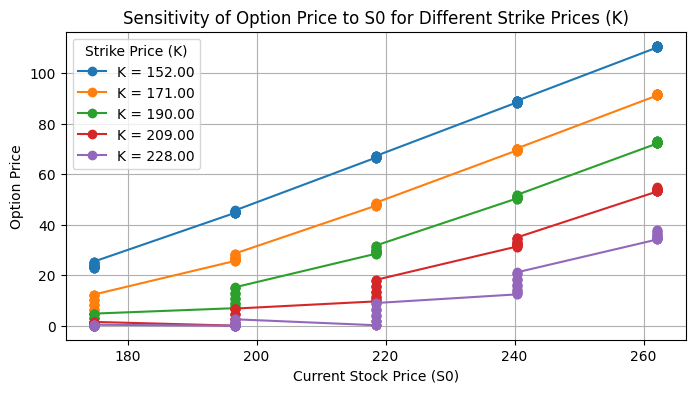

In [ ]:
plt.figure(figsize = (8, 4))

for K in K_range:
    subset = results_df[
        (results_df['K'] == K) &
        (np.isclose(results_df['T'], T_range[0])) &
        (results_df['num_steps'] == 500)]

    if subset.empty:
        print(f"Subset is empty for K = {K}, T = {T_range[0]}, num_steps = 500")
    else:
        plt.plot(subset['S0'], subset['price'], label=f'K = {K:.2f}', marker='o')

plt.xlabel('Current Stock Price (S0)')
plt.ylabel('Option Price')
plt.title('Sensitivity of Option Price to S0 for Different Strike Prices (K)')
plt.legend(title='Strike Price (K)', loc='best')
plt.grid(True)
plt.show()

## **Table 10. Numerical convergence**

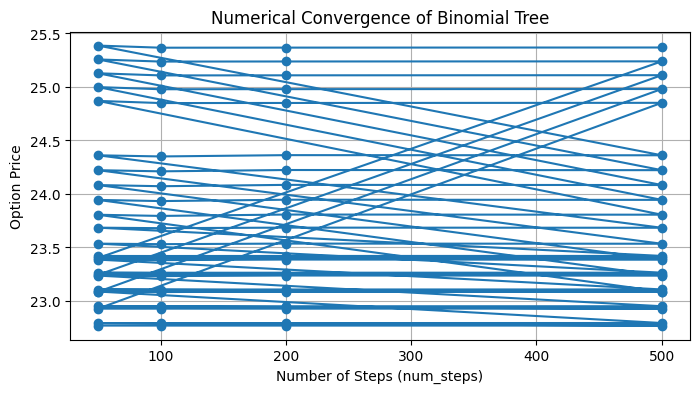

In [ ]:
plt.figure(figsize = (8, 4))

subset = results_df[(results_df['S0'] == S0_range[0]) &
                   (results_df['K'] == K_range[0]) &
                   (results_df['T'] == T_range[0])]

plt.plot(subset['num_steps'], subset['price'], marker='o')
plt.xlabel('Number of Steps (num_steps)')
plt.ylabel('Option Price')
plt.title('Numerical Convergence of Binomial Tree')
plt.grid(True)
plt.show()

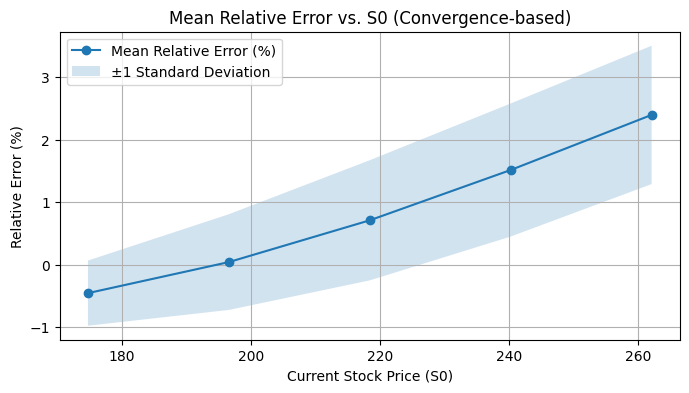

In [ ]:
results_df['relative_error'] = (results_df['price'] - results_df['price'].iloc[0]) / results_df['price'].iloc[0]
mean_relative_error = results_df.groupby('S0')['relative_error'].mean()
std_relative_error = results_df.groupby('S0')['relative_error'].std()

plt.figure(figsize = (8, 4))
plt.plot(mean_relative_error.index, mean_relative_error.values, label = 'Mean Relative Error (%)', marker = 'o')
plt.fill_between(
    mean_relative_error.index,
    mean_relative_error.values - std_relative_error.values,
    mean_relative_error.values + std_relative_error.values,
    alpha = 0.2,
    label = '±1 Standard Deviation')
plt.xlabel('Current Stock Price (S0)')
plt.ylabel('Relative Error (%)')
plt.title('Mean Relative Error vs. S0 (Convergence-based)')
plt.legend()
plt.grid(True)
plt.show()

## **Table 11. AMZN price**

[*********************100%***********************]  1 of 1 completed


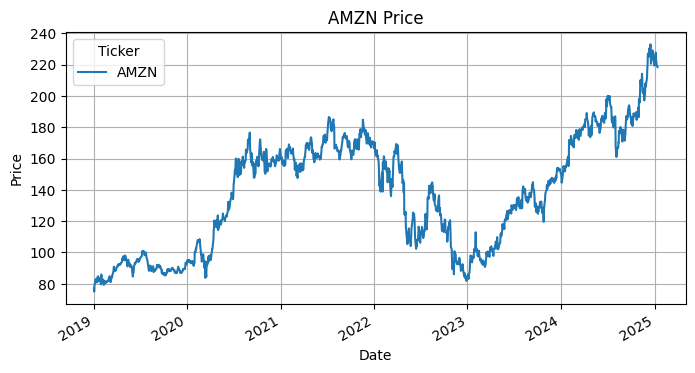

Mean Volatility: 0.021688060355921513
Min Volatility: 0.01312477144213221


In [ ]:
ticker = "AMZN"
data = yf.download(ticker, start="2019-01-01")["Close"]
data.plot(figsize=(8, 4), title="AMZN Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()

returns = np.log(data / data.shift(1)) * 100
returns.dropna(inplace = True)
historical_volatility = returns.rolling(window = 252).std() / 100
volatility = historical_volatility.dropna().values

print("Mean Volatility:", np.mean(volatility))
print("Min Volatility:", np.min(volatility))

## **Table 12. ADF tests for unit root**

In [ ]:
result = adfuller(returns)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -39.98156679397701
p-value: 0.0


## **Table 13. ACF & PACF plots**

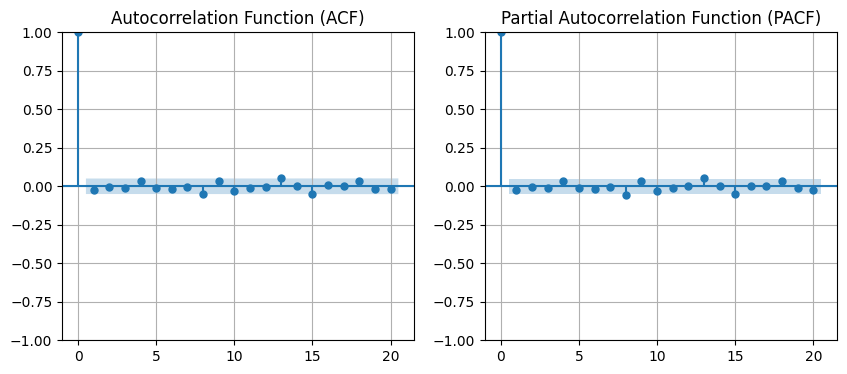

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(returns, lags=20, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")
ax1.grid()

plot_pacf(returns, lags=20, ax=ax2)
ax2.set_title("Partial Autocorrelation Function (PACF)")
ax2.grid()
plt.show()

## **Table 14. Payoff profiles for a call option and a put option at a fixed strike price**

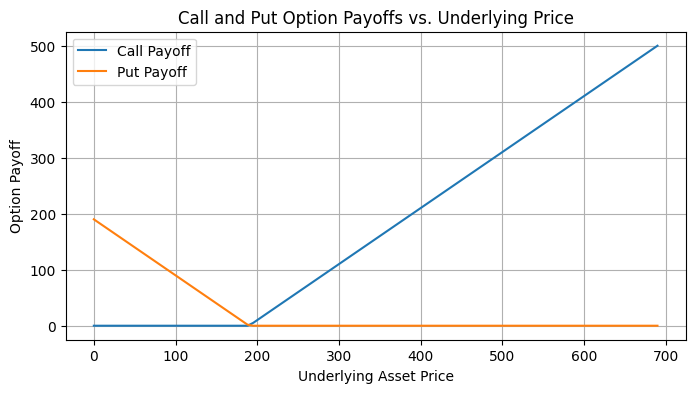

In [ ]:
K_call = 190.0
K_put = 190.0

min_strike = min(calls_strike_prices.min(), puts_strike_prices.min())
max_strike = max(calls_strike_prices.max(), puts_strike_prices.max())

S0 = np.linspace(0, 2 * max_strike, 100)

call_payoff = np.maximum(S0 - K_call, 0)
put_payoff = np.maximum(K_put - S0, 0)

plt.figure(figsize=(8, 4))
plt.plot(S0, call_payoff, label="Call Payoff")
plt.plot(S0, put_payoff, label="Put Payoff")
plt.xlabel("Underlying Asset Price")
plt.ylabel("Option Payoff")
plt.title("Call and Put Option Payoffs vs. Underlying Price")
plt.grid(True)
plt.legend()
plt.show()

## **Table 15. Experiment with different volatilities**

[*********************100%***********************]  1 of 1 completed


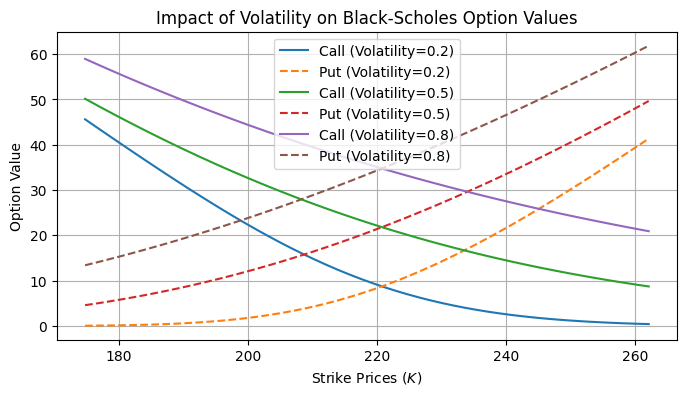

In [ ]:
S0 = get_current_stock_price(ticker)
date = '2025-04-17'
T = get_date(date)
r = get_13wk_treasury_rate().iloc[0]
r = r / 100
volatility_values = [0.2, 0.5, 0.8]
strike_prices = np.linspace(S0 * 0.8, S0 * 1.2, 50)

plt.figure(figsize=(8, 4))

def BS_CALL(S, K, T, r, sigma):
    epsilon = 1e-10
    d1 = (np.log((S / K) + epsilon) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def BS_PUT(S, K, T, r, sigma):
    epsilon = 1e-10
    d1 = (np.log((S / K) + epsilon) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

for sigma in volatility_values:
    calls = []
    puts = []
    for K in strike_prices:
        call_price = BS_CALL(S0, K, T, r, sigma)
        put_price = BS_PUT(S0, K, T, r, sigma)
        calls.append(call_price)
        puts.append(put_price)

    plt.plot(strike_prices, calls, label=f'Call (Volatility={sigma})')
    plt.plot(strike_prices, puts, linestyle='--', label=f'Put (Volatility={sigma})')

plt.xlabel('Strike Prices ($K$)')
plt.ylabel('Option Value')
plt.title('Impact of Volatility on Black-Scholes Option Values')
plt.legend()
plt.grid(True)
plt.show()

## **Table 16. GARCH-Black Scholes model to estimate time varying volatility**

In [ ]:
log_returns = np.log(data / data.shift(1)).dropna()
log_returns_rescaled = log_returns * 100

daily_volatility = np.std(log_returns, axis=0)
print("Daily Volatility:", daily_volatility)
annualized_volatility = daily_volatility * np.sqrt(252)
print("Annualized Volatility:", annualized_volatility)

garch_model = arch_model(log_returns_rescaled, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp="off")

omega = garch_fit.params['omega']
alpha = garch_fit.params['alpha[1]']
beta = garch_fit.params['beta[1]']
print()
print('Optimal values for GARCH(1, 1) parameters:')
print(f'\tω = {omega:.12f}, α = {alpha:.5f}, β = {beta:.5f}')

Daily Volatility: Ticker
AMZN    0.021461
dtype: float64
Annualized Volatility: Ticker
AMZN    0.340686
dtype: float64

Optimal values for GARCH(1, 1) parameters:
	ω = 0.284230035177, α = 0.16994, β = 0.77849


## **Table 17. GARCH-Based Forward Variance and Volatility Projection to the Next Options Expiration Date**

In [ ]:
today = date.today()
next_january = today.replace(year=today.year + 1, month=1, day=1)
maturity_date = next_january + relativedelta(weekday=FR(3))
days_to_maturity = (maturity_date - today).days
term_in_years = days_to_maturity / 252

forecast_variance = garch_fit.conditional_volatility.iloc[-1]**2
for _ in range(days_to_maturity):
    forecast_variance = omega + alpha * forecast_variance + beta * forecast_variance

forecast_volatility_annualized = np.sqrt(forecast_variance * 252) / 100
print(f"Volatility of AMZN for term {term_in_years:.4f} years: {forecast_volatility_annualized:.5f}")

Volatility of AMZN for term 1.4563 years: 0.37266


## **Table 18. Comparison of Historical and Forward-Looking Volatility Based on a GARCH(1,1) Model**

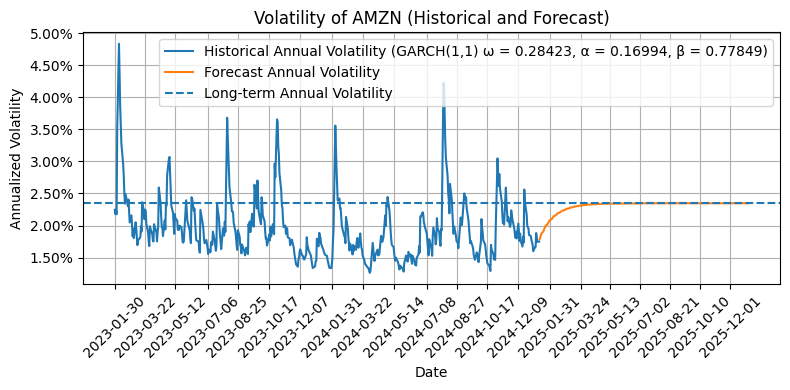

In [ ]:
fitted_variances = garch_fit.conditional_volatility ** 2
current_variance = fitted_variances.iloc[-1]

n_days_forecast = 252
forecasted_volatility = []
variance = current_variance

for _ in range(n_days_forecast):
    variance = omega + alpha * variance + beta * variance
    forecasted_volatility.append(np.sqrt(variance))

forecasted_volatility = np.array(forecasted_volatility) / 100
forecast_dates = pd.date_range(start=fitted_variances.index[-1], periods=n_days_forecast + 1, freq='B')[1:]

n_days_to_skip = 10
historical_volatility = np.sqrt(fitted_variances) / 100
historical_volatility_dates = fitted_variances.index

long_term_volatility = np.sqrt(omega / (1 - alpha - beta)) / 100

recent_date_cutoff = historical_volatility_dates[-1] - pd.DateOffset(years=2)
filtered_historical_volatility = historical_volatility[historical_volatility_dates >= recent_date_cutoff]
filtered_historical_volatility_dates = historical_volatility_dates[historical_volatility_dates >= recent_date_cutoff]

filtered_forecast_dates = forecast_dates[forecast_dates >= recent_date_cutoff]
filtered_forecast_volatility = forecasted_volatility[:len(filtered_forecast_dates)]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(
    filtered_historical_volatility_dates[n_days_to_skip:],
    filtered_historical_volatility[n_days_to_skip:],
    label=f'Historical Annual Volatility (GARCH(1,1) ω = {omega:.5f}, α = {alpha:.5f}, β = {beta:.5f})')
ax.plot(
    filtered_forecast_dates,
    filtered_forecast_volatility,
    label='Forecast Annual Volatility')
ax.axhline(
    long_term_volatility,
    xmin=0,
    xmax=1,
    label="Long-term Annual Volatility",
    linestyle='--')
ax.legend()
ax.grid(True)

x_axis_ticks = np.append(
    filtered_historical_volatility_dates[n_days_to_skip:],
    filtered_forecast_dates)[::36]
ax.set_xticks(x_axis_ticks)
ax.set_xticklabels(pd.to_datetime(x_axis_ticks).strftime('%Y-%m-%d'), rotation=45)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_title(f'Volatility of {ticker} (Historical and Forecast)')
ax.set_ylabel('Annualized Volatility')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

## **Table 19. Computation of Black–Scholes Call Price Based on Forward-Looking Volatility and Market Data Retrieval**

In [ ]:
def get_current_stock_price(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    return current_price

def get_13wk_treasury_rate():
    treasury_ticker = "^IRX"
    treasury_data = yf.download(treasury_ticker, period="1d")
    last_yield = treasury_data['Close'].iloc[-1].item()
    return last_yield

def get_date(date_str):
    date_object = datetime.strptime(date_str, '%Y-%m-%d')
    current_date = datetime.now()
    years_difference = (date_object - current_date).days / 365.25
    return max(years_difference, 0)

ticker = "AMZN"
date = '2025-04-17'

S0 = get_current_stock_price(ticker)
T = get_date(date)
r = get_13wk_treasury_rate() / 100

option = yf.Ticker(ticker)
calls = option.option_chain(date).calls
strike_prices = calls['strike'].tolist()
K = strike_prices[23]
sigma = forecast_volatility_annualized

def BS_CALL(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price, d1, d2

print()
print(f"Stock Price (S0): {S0}")
print(f"Strike Price (K): {K}")
print(f"Time to Maturity (T): {T} years")
print(f"Risk-Free Rate (r): {r}")
print(f"Implied Volatility (σ): {sigma}")

print()
option_price, d1_value, d2_value = BS_CALL(S0, K, T, r, sigma)
print(f"\nBlack-Scholes Call Option Price: {option_price}")
print(f"d1: {d1_value}")
print(f"d2: {d2_value}")

[*********************100%***********************]  1 of 1 completed


Stock Price (S0): 218.4600067138672
Strike Price (K): 200.0
Time to Maturity (T): 0.2518822724161533 years
Risk-Free Rate (r): 0.04217999935150146
Implied Volatility (σ): 0.3726573913791076


Black-Scholes Call Option Price: 27.908216232972734
d1: 0.6223633240637795
d2: 0.4353345010049705



## **Table 20. Greeks estimations**

In [ ]:
def delta_call(S0, K, T, r, sigma):
    return norm.cdf(d1(S0, K, T, r, sigma))

def gamma_call(S0, K, T, r, sigma):
    numerator = norm.pdf(d1(S0, K, T, r, sigma))
    denominator = S0 * sigma * sqrt(T)
    return numerator / denominator

def vega_call(S0, K, T, r, sigma):
    return S0 * norm.pdf(d1(S0, K, T, r, sigma)) * sqrt(T)

def theta_call(S0, K, T, r, sigma):
    numerator = S0 * norm.pdf(d1(S0, K, T, r, sigma)) * sigma
    denominator = 2 * sqrt(T)
    theta_1 = -1 * (numerator / denominator)
    theta_2 = -r * K * exp(-r * T) * norm.cdf(d2(S0, K, T, r, sigma))
    return theta_1 + theta_2

def rho_call(S0, K, T, r, sigma):
    return K * T * exp(-r * T) * norm.cdf(d2(S0, K, T, r, sigma))

S0 = get_current_stock_price(ticker)
T = get_date(date)
r = get_13wk_treasury_rate() / 100

option = yf.Ticker(ticker)
calls = option.option_chain(date).calls
strike_prices = calls['strike'].tolist()
K = strike_prices[23]
sigma = forecast_volatility_annualized

# Calculate Greeks
delta = delta_call(S0, K, T, r, sigma)
gamma = gamma_call(S0, K, T, r, sigma)
vega = vega_call(S0, K, T, r, sigma)
theta = theta_call(S0, K, T, r, sigma)
rho = rho_call(S0, K, T, r, sigma)

# Display results
print(f"Delta (Δ): {delta:.4f}")
print(f"Gamma (Γ): {gamma:.4f}")
print(f"Vega (ν): {vega:.4f}")
print(f"Theta (Θ): {theta:.4f}")
print(f"Rho (ρ): {rho:.4f}")

[*********************100%***********************]  1 of 1 completed


Delta (Δ): 0.7331
Gamma (Γ): 0.0080
Vega (ν): 36.0389
Theta (Θ): -32.2382
Rho (ρ): 33.3128


In [ ]:
def get_yield_curve_fred(treasury_symbols, start_date, end_date=None):
    if end_date is None:
        end_date = datetime.date.today()

    yields_df = pd.DataFrame()

    for symbol in treasury_symbols:
        try:
            data = web.DataReader(symbol, 'fred', start_date, end_date)
            data = data.rename(columns={'VALUE': symbol})

            if yields_df.empty:
                yields_df = data
            else:
                yields_df = yields_df.join(data, how='outer')

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    return yields_df

treasury_symbols = ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2',
                    'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
start_date = datetime.date(2023, 1, 1)

yield_curve_df = get_yield_curve_fred(treasury_symbols, start_date)
print(yield_curve_df.iloc[-1])

DFF       4.33
DGS1MO    4.42
DGS3MO    4.37
DGS6MO    4.30
DGS1      4.24
DGS2      4.40
DGS3      4.49
DGS5      4.61
DGS7      4.71
DGS10     4.79
DGS20     5.05
DGS30     4.97
Name: 2025-01-13 00:00:00, dtype: float64


## **Table 21. Riskless Yield**

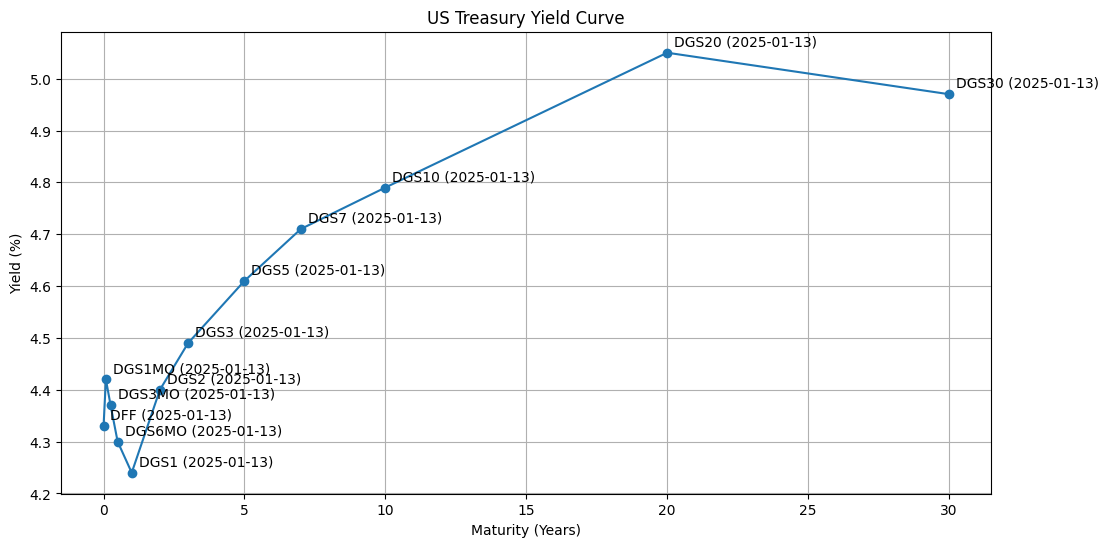

In [ ]:
latest_yields = yield_curve_df.iloc[-1].dropna()

maturities = ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2',
              'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
available_maturities = latest_yields.index.tolist()
maturity_mapping = {
    'DFF': 0,
    'DGS1MO': 1 / 12,
    'DGS3MO': 3 / 12,
    'DGS6MO': 6 / 12,
    'DGS1': 1,
    'DGS2': 2,
    'DGS3': 3,
    'DGS5': 5,
    'DGS7': 7,
    'DGS10': 10,
    'DGS20': 20,
    'DGS30': 30}

numerical_maturities = [maturity_mapping[maturity] for maturity in available_maturities]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(numerical_maturities, latest_yields.values, marker='o')
ax.set_title('US Treasury Yield Curve')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Yield (%)')
ax.grid(True)

dates = yield_curve_df.index[-1]

for i, txt in enumerate(available_maturities):
    ax.annotate(f"{txt} ({dates.strftime('%Y-%m-%d')})",
                (numerical_maturities[i], latest_yields.values[i]),
                xytext = (5,5), textcoords = 'offset points')

plt.show()